In [1]:
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms
import os
import numpy as np
import time
from PIL import Image
#from PIL import ImageFile
#ImageFile.LOAD_TRUNCATED_IMAGES = True
from collections import defaultdict
import cv2
import pdb
IMG_SIZE = (224,224)
import pandas as pd
from torchvision import models
from torchsummary import summary
import copy
import matplotlib.pyplot as plt
import torch
from skimage import io, transform
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torch.utils.data as data_utils
import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F 
import numpy as np


In [2]:
class Emotion_Dataset(Dataset):
    """Emotion dataset."""

    def __init__(self, csv_file, root_dir, transform=None,v_transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.v_transform = v_transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
            
            
        
       
        #img_name = os.path.join(self.data_frame.iloc[idx, 22],
        #                        self.data_frame.iloc[idx, 0])

        ses_dir = self.data_frame.iloc[idx, 22].split('/')[-2]
        #i_path = "/home/mandeep_stanford/cs231n_project/code/pre-processed_data/4_EMOTIONS/with_noise_cleanup/"
        i_path = "/home/mandeep_stanford/cs231n_project/code/pre-processed_data/4_EMOTIONS/cb_removed/without_noise_cleanup/"
        img_p = i_path + ses_dir + "/"
        index_ = self.data_frame.iloc[idx, 0].split('_Same_ColorBAR.png')[0].split('_')
        index_[4] = "0"
        aa = "_".join(index_)
        #pdb.set_trace()
        img_f_name = aa + "_Whole_Length_Same_ColorBAR.png"



        #img_name = img_p + self.data_frame.iloc[idx, 0]
        img_name = img_p + img_f_name

        

        #img_name = img_p + self.data_frame.iloc[idx, 0]
        #img_name = img_p + img_f_name

        #img_name = os.path.join(self.data_frame.iloc[idx, 22],
        #                        self.data_frame.iloc[idx, 0])
        #image = io.imread(img_name)
        image = Image.open(img_name)
        image = image.convert('RGB')
        image = image.crop((20,190,380,280))
        #tr = transforms.ToTensor()
        #image = tr(image)
        #landmarks = self.data_frame.iloc[idx, 21]
        #landmarks = np.array([landmarks])
        #landmarks = landmarks.astype('float').reshape(-1, 2)
        emotion = self.data_frame.iloc[idx,21]
        emotion = np.array([emotion])
        emotion = emotion.astype('int').reshape((1))
        
        ######################
        X = []
        for i in range(1,21):
            v_img_name = os.path.join(self.data_frame.iloc[idx, 22],
                                self.data_frame.iloc[idx, i])
            v_image = Image.open(v_img_name)
            v_image = image.convert('RGB')
            v_image = v_image.crop((110,30,300,140))
            if self.v_transform:
                v_image = self.v_transform(v_image)
                           
            X.append(v_image)
        X = torch.stack(X, dim=0).transpose(1,0)
        
        ######################
        sample = {'image': image, 'emotion': emotion, 'video': X}

        if self.transform:
            sample['image'] = self.transform(sample['image'])

        return sample
    

In [3]:
def show_emotion_audio(image, emotion, video):
    """Show image with landmarks"""
    #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.imshow(image)
    #plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.title(emotion)
    #plt.imshow()
    plt.pause(0.001)  # pause a bit so that plots are updated

0 torch.Size([3, 200, 300]) (1,) torch.Size([3, 20, 60, 100])
1 torch.Size([3, 200, 300]) (1,) torch.Size([3, 20, 60, 100])
2 torch.Size([3, 200, 300]) (1,) torch.Size([3, 20, 60, 100])
3 torch.Size([3, 200, 300]) (1,) torch.Size([3, 20, 60, 100])


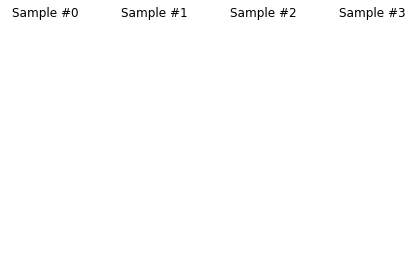

In [4]:
composed = transforms.Compose([
                                    transforms.Resize((200,300)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                              
                              ])

v_composed = transforms.Compose([
                                    transforms.Resize((60,100)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                              
                              ])
root_dir = "/home/mandeep_stanford/cs231n_project/code/pre-processed_data/4_EMOTIONS/cb_removed/without_noise_cleanup/"
emotion_dataset = Emotion_Dataset(csv_file=root_dir + 'not_hap_data_TRAIN.csv',
                                    root_dir=root_dir, transform=composed, v_transform = v_composed)



############################

fig = plt.figure()

for i in range(len(emotion_dataset)):
    sample = emotion_dataset[i]

    print(i, sample['image'].shape, sample['emotion'].shape, sample['video'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    #show_emotion_audio(**sample)

    if i == 3:
        plt.show()
        break


In [5]:
total_images = len(emotion_dataset)
test_data_images = np.int(total_images*0.2)
train_data_images = total_images - test_data_images
print("Train image count",train_data_images)
print("Test image count",test_data_images)
#loader_train = DataLoader(emotion_dataset, batch_size=64, sampler=sampler.SubsetRandomSampler(range(0,train_data_images)))

# loader_val = DataLoader(emotion_dataset, batch_size=64, sampler=sampler.SubsetRandomSampler(range(train_data_images, train_data_images+test_data_images)))
loader_train = DataLoader(emotion_dataset, batch_size=64)

Train image count 3840
Test image count 960


In [6]:
for t, x in enumerate(loader_train):
    print(t, x['image'].shape, x['emotion'], x['video'].shape)
    #print(x,y)
    if t == 1:
        break
    

0 torch.Size([64, 3, 200, 300]) tensor([[1],
        [2],
        [3],
        [1],
        [2],
        [3],
        [1],
        [2],
        [3],
        [1],
        [2],
        [3],
        [1],
        [2],
        [3],
        [1],
        [2],
        [3],
        [1],
        [2],
        [3],
        [1],
        [2],
        [3],
        [1],
        [2],
        [3],
        [1],
        [2],
        [3],
        [1],
        [2],
        [3],
        [1],
        [2],
        [3],
        [1],
        [2],
        [3],
        [1],
        [2],
        [3],
        [1],
        [2],
        [3],
        [1],
        [2],
        [3],
        [1],
        [2],
        [3],
        [1],
        [2],
        [3],
        [1],
        [2],
        [3],
        [1],
        [2],
        [3],
        [1],
        [2],
        [3],
        [1]]) torch.Size([64, 3, 20, 60, 100])
1 torch.Size([64, 3, 200, 300]) tensor([[2],
        [3],
        [1],
        [2],
        [3],
     

In [7]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)
# device = torch.device('cpu')

using device: cuda


In [8]:
print_every = 1
print_every_sup=20

In [9]:
def check_train_accuracy11(loader, model):
    #if loader.dataset.train:
    #    print('Checking accuracy on validation set')
    #else:
    #    print('Checking accuracy on test set')
    print('Checking accuracy on TRAIN set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for da in loader:
            #pdb.set_trace()
            #x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            #y = y.to(device=device, dtype=torch.long)
            x = da['image']
            y = da['emotion']
            v = da['video']
            y = y.reshape(y.shape[0])
            x = x.to(device)
            y = y.to(device)
            v = v.to(device)
            #pdb.set_trace()
            #y = torch.stack(y) #.to(device=device)
            #y = y.reshape((x.shape[0]))
            scores = model(x,v)
            _, preds = scores.max(1)
            
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc


def check_train_accuracy(loader, model):
    #if loader.dataset.train:
    #    print('Checking accuracy on validation set')
    #else:
    #    print('Checking accuracy on test set')
    print('Checking accuracy on TRAIN set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y, v in loader:
            #pdb.set_trace()
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            v = v.to(device=device, dtype=dtype)
            #pdb.set_trace()
            #y = torch.stack(y) #.to(device=device)
            #y = y.reshape((x.shape[0]))
            scores = model(x,v)
            _, preds = scores.max(1)
            
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc
    
def check_accuracy_part34(loader, model):
    #if loader.dataset.train:
    #    print('Checking accuracy on validation set')
    #else:
    #    print('Checking accuracy on test set')
    print('Checking accuracy on VAL set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for da in loader:
            #pdb.set_trace()
            x = da['image']
            y = da['emotion']
            v = da['video']
            y = y.reshape(y.shape[0])
            x = x.to(device)
            y = y.to(device)
            v = v.to(device)
            #x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            #y = y.to(device=device, dtype=torch.long)
            #pdb.set_trace()
            #y = torch.stack(y) #.to(device=device)
            #y = y.reshape((x.shape[0]))
            scores = model(x,v)
            _, preds = scores.max(1)
            
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        return acc
    
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    acc = 0
    per_epoch_train_accuracy_list = []
    per_epoch_test_accuracy_list = []
    train_accuracy_list = []
    test_accuracy_list = []
    loss_list = []
    best_model = model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, da in enumerate(loader_train):
            #import pdb
            #pdb.set_trace()
            model.train()  # put model to training mode
            x = da['image']
            y = da['emotion']
            v = da['video']
            y = y.reshape(y.shape[0])
            x = x.to(device)
            y = y.to(device)
            v = v.to(device)
            #x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            #y = y.to(device=device, dtype=torch.long)
            #y = torch.stack(y) #.to(device=device)
            #y = y.reshape((x.shape[0]))
            scores = model(x,v)
            
            loss = F.cross_entropy(scores, y)
            loss_list.append(loss.item())
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()
            #pdb.set_trace()
            #print("IN ITERATION", t)
            if t % print_every_sup == 0:
                print('Epoch %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
                #pdb.set_trace()
                xx = x.cpu().data.numpy()
                yy = y.cpu().data.numpy()
                vv = v.cpu().data.numpy()
                tt_data = []
                for i in range(len(xx)):
                  #ind = np.where(keys_array==Y[i]) 
                  tt_data.append([xx[i], yy[i], vv[i]])
                
                train_d = DataLoader(tt_data, batch_size = 1)
                
                train_acc = check_train_accuracy(train_d, model)
                train_accuracy_list.append(train_acc)
                test_acc = check_accuracy_part34(loader_val, model)
                test_accuracy_list.append(test_acc)
                if test_acc > acc:
                  acc = test_acc
                  best_model = copy.deepcopy(model)
                  torch.save(best_model, "best_model_AV_CNN_RNN_3DCNN_without_noise_cleanup_3sec_Time_Scale_50_epochs")
                print()
#             if t == 2:
#                 break
        e_test_accuracy = check_accuracy_part34(loader_val, model)        
        per_epoch_test_accuracy_list.append(e_test_accuracy)     
        e_train_accuracy = check_train_accuracy11(loader_train, model)        
        per_epoch_train_accuracy_list.append(e_train_accuracy)     
    return best_model, acc, train_accuracy_list, test_accuracy_list, per_epoch_train_accuracy_list, per_epoch_test_accuracy_list, loss_list 

In [10]:
def contrastive_loss(x_images,x_videos,relation_labels,margin):
    distance_l2=torch.sqrt(torch.sum(torch.pow(torch.add(x_images,torch.mul(x_videos,-1)),2),axis=1))
    contra_loss_first=relation_labels*torch.pow(distance_l2,2)
    contra_loss_second=(1-relation_labels)*torch.pow(torch.clamp(margin-distance_l2,max=0),2)
    contra_loss=torch.mean(contra_loss_first+contra_loss_second)
    
    return contra_loss

def batch_contrastive_loss(model_audio,model_video,x,v,y,margin):
    #initialize contrastive loss to zero
    contra_loss=0
    
    #computing contrastive loss for positive pairs
    relation_labels_positive=torch.ones(y.shape).to(device=device)
    results_image = model_audio(x)
    results_video = model_video(v)
    contra_loss+=contrastive_loss(results_image,results_video,relation_labels_positive,margin)
    
    #computing contrastive loss for hard and super hard negative pairs
    batch_size=x.shape[0]
    hard_neg_size=int(batch_size*0.75)
    super_neg_size=int(batch_size*0.25)
#     print(batch_size)
    image_hard=torch.zeros(x[:hard_neg_size,...].shape).to(device=device)
    video_hard=torch.zeros(v[:hard_neg_size,...].shape).to(device=device)
    image_super=torch.zeros(x[:super_neg_size,...].shape).to(device=device)
    video_super=torch.zeros(v[:super_neg_size,...].shape).to(device=device)
#     import pdb
#     pdb.set_trace()
    
    for i in range(hard_neg_size):
        image_hard[i,...]=x[i,...]
        video_hard[i,...]=v[i+1,...]
        if i<super_neg_size:
            image_super[i,...]=x[i,...]
            video_super[i,...]=v[i+4,...]
            
    results_image_hard = model_audio(image_hard)
    results_video_hard = model_video(video_hard)
    relation_labels_hard=torch.zeros(y[:hard_neg_size,...].shape).to(device=device)
    contra_loss+=contrastive_loss(results_image_hard,results_video_hard,relation_labels_hard,margin)
    
    results_image_super = model_audio(image_super)
    results_video_super = model_video(video_super)
    relation_labels_super=torch.zeros(y[:super_neg_size,...].shape).to(device=device)
    contra_loss+=contrastive_loss(results_image_super,results_video_super,relation_labels_super,margin)
    
      
    #computing contrastive loss for super hard negative pairs
#     batch_size=x.shape[0]
#     super_neg_size=int(batch_size*0.25)
#     print(batch_size)
#     image_super=torch.zeros(x[super_neg_size,...].shape).to(device=device)
#     video_super=torch.zeros(v[super_neg_size,...].shape).to(device=device)
#     for i in range(super_neg_size):
#         image_super[i]=x[i,...]
#         video_super[i]=v[i+4,...]
#     results_image_super = model_audio(image_super)
#     results_video_super = model_video(video_super)
#     relation_labels_super=torch.zeros(y[super_neg_size,...].shape).to(device=device)
#     contra_loss+=contrastive_loss(results_image_super,results_video_super,relation_labels_super,margin)
    
    return contra_loss
                           
def check_train_accuracy_self_supervised(loader, model_audio,model_video):
    #if loader.dataset.train:
    #    print('Checking accuracy on validation set')
    #else:
    #    print('Checking accuracy on test set')
    print('Checking contrastive loss on TRAIN set')
#     num_correct = 0
    contra_loss = 0
    model_audio.eval()  # set model to evaluation mode
    model_video.eval()
    with torch.no_grad():
        for da in loader:
            #pdb.set_trace()
            #x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            #y = y.to(device=device, dtype=torch.long)
            x = da['image']
            y = da['emotion']
            v = da['video']
            y = y.reshape(y.shape[0])
            x = x.to(device)
            y = y.to(device)
            v = v.to(device)
            #pdb.set_trace()
            #y = torch.stack(y) #.to(device=device)
            #y = y.reshape((x.shape[0]))
            relation_labels=torch.ones(y.shape)
            results_image = model_audio(x)
            results_video = model_video(v)
            contra_loss+=contrastive_loss(results_image,results_video,relation_labels,margin)
        print('Got correct (%.2f)' % (contra_loss/len(enumerate(loader))))
        return contra_loss/len(enumerate(loader))


                           
def check_accuracy_part_self_supervised(loader, model_audio,model_video):
    #if loader.dataset.train:
    #    print('Checking accuracy on validation set')
    #else:
    #    print('Checking accuracy on test set')
    print('Checking contastive loss on VAL set')
    contra_loss = 0
#     num_samples = 0
    model_audio.eval()  # set model to evaluation mode
    model_video.eval()
    with torch.no_grad():
        for da in loader:
            #pdb.set_trace()
            x = da['image']
            y = da['emotion']
            v = da['video']
            y = y.reshape(y.shape[0])
            x = x.to(device)
            y = y.to(device)
            v = v.to(device)
            #x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            #y = y.to(device=device, dtype=torch.long)
            #pdb.set_trace()
            #y = torch.stack(y) #.to(device=device)
            #y = y.reshape((x.shape[0]))
                           
            relation_labels=torch.ones(y.shape).to(device=device)
            results_image = model_audio(x)
            results_video = model_video(v)
            contra_loss+=contrastive_loss(results_image,results_video,relation_labels,margin)
#             scores = model(x,v)
#             _, preds = scores.max(1)
            
            
#             num_correct += (preds == y).sum()
#             num_samples += preds.size(0)
#         acc = float(num_correct) / num_samples
        print('Got loss(%.2f)' % (contra_loss/len(enumerate(loader))))
        return contra_loss/len(enumerate(loader))

    
    
    
    
    
def train_part_self_supervised(model_audio,model_video, optimizer_audio,optimizer_video, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    margin=1
    loss = 1e8
    per_epoch_train_loss_list = []
    loss_list = []
    best_model_audio = model_audio = model_audio.to(device=device)  # move the model parameters to CPU/GPU
    best_model_video = model_video = model_video.to(device=device)
    for e in range(epochs):
        for t, da in enumerate(loader_train):
            if da['image'].shape[0]<64:
                continue
            #import pdb
            #pdb.set_trace()
            model_audio.train()  # put model to training mode
            model_video.train()
            x = da['image']
            y = da['emotion']
            v = da['video']
            y = y.reshape(y.shape[0])
            x = x.to(device)
            y = y.to(device)
            v = v.to(device)
            contra_loss=batch_contrastive_loss(model_audio,model_video,x,v,y,margin)
            
            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer_audio.zero_grad()
            optimizer_video.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            contra_loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer_audio.step()
            optimizer_video.step()

            if t % print_every == 0:
                loss_list.append(contra_loss.item())
                if contra_loss < loss:
                      loss = contra_loss
                      best_model_audio = copy.deepcopy(model_audio)
                      best_model_video = copy.deepcopy(model_video)        
                      torch.save(best_model_audio, "best_model_audio_self_supervised_without_noise_cleanup_3sec_Time_Scale_50_epochs.pt")
                      print("saving best audio model")
                      torch.save(best_model_video, "best_model_video_self_supervised_without_noise_cleanup_3sec_Time_Scale_50_epochs.pt")
                      print("saving best video model")
            print(f"Contrastive loss {contra_loss} of iteration {t}, epoch {e}")
#             if t == 2:
#                 break        
        per_epoch_train_loss_list.append(contra_loss.item())     
    return best_model_audio,best_model_video, per_epoch_train_loss_list, loss_list 

In [11]:
class Flatten(nn.Module):
    def flatten(x):
        N = x.shape[0] # read in N, C, H, W
        return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

    def forward(self, x):
        N = x.shape[0]
        return x.view(N, -1)

class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        #self.model = nn.LSTM(input_size=(32*25*37),hidden_size=128,num_layers=2,batch_first=True,bidirectional =True, dropout=0.1)
        self.model = nn.RNN(input_size=(32*25*37),hidden_size=128,num_layers=2,batch_first=True,bidirectional =True, dropout=0.1)
    def forward(self, x):

        # From [batches, seqs, seq len, features]
        # to [seq len, batch data, features]
        x = x.unsqueeze(1)
       
        # Data is fed to the LSTM
        out, _ = self.model(x)

        # From [seq len, batch, num_directions * hidden_size]
        # to [batches, seqs, seq_len,prediction]
        out = out.squeeze(1)


        return out

#hidden_layer_size = 500
#learning_rate = 1e-2

#model = nn.Sequential(
#    Flatten(),
#    nn.Linear(3 * 200 * 300, hidden_layer_size),
#    nn.ReLU(),
#    nn.Linear(hidden_layer_size, keys_array.shape[0]),
#)


vl1 = nn.Sequential(
            nn.Conv3d(3, 16, kernel_size=(3,3,3), padding=(0,0,0), stride=1),
            nn.ReLU(),
            nn.MaxPool3d( kernel_size=(1,3,3), stride=(1,2,2)),
            nn.Conv3d(16, 32, kernel_size=(3,3,3), padding=(0,0,0), stride=1),
            nn.ReLU(),
            nn.MaxPool3d( kernel_size=(1,3,3), stride=(1,2,2)),
            
            
            nn.Conv3d(32, 64, kernel_size=(3,3,3), padding=(0,0,0), stride=1),
            nn.ReLU(),
            nn.MaxPool3d( kernel_size=(1,3,3), stride=(1,2,2)),
            
    
            nn.Conv3d(64, 128, kernel_size=(3,3,3), padding=(0,0,0), stride=1),
            nn.ReLU(),
            Flatten()
    
)

'''
for t, x in enumerate(loader_train):
            # put model to training mode
            pdb.set_trace()
            xx = x['video']
            hh = l1(xx)
            hh.shape
            #x = x.to(device=device, dtype=dtype)
            #import pdb
            #pdb.set_trace()
            break
'''




l2 = nn.Sequential(
            nn.Conv2d(16, 24, kernel_size=(8,12), padding=(4,6), stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
)
#h = l2(h)

l3 = nn.Sequential(
            nn.Conv2d(24, 32, kernel_size=(5,7), padding=(2,3), stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            Flatten(),
            LSTM()
            
)

#l4 = nn.Sequential(
#            nn.Conv2d(channel_3, channel_4, kernel_size=3, padding=1, stride=1),
#            nn.MaxPool2d(2, 1)
#)

#import pdb
#pdb.set_trace()
hidden_layer_size = 4
learning_rate = 1e-4 #1e-4   1e-3 looks gud
model_video = nn.Sequential(
            vl1,
            nn.Linear(21504, 256),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(256, 64)
)

#######################################AUDIO###############################

al1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(12,16), padding=(6,8), stride=1),
            nn.ReLU(),
            #nn.Conv2d(channel_1, channel_1, kernel_size=5, padding=2, stride=1),
            nn.MaxPool2d(2, 2)
)
'''
for t, (x, y) in enumerate(loader_train):
            # put model to training mode
            x = x.to(device=device, dtype=dtype)
            import pdb
            pdb.set_trace()
            break
    
pdb.set_trace()
h = l1(x)
h.shape
'''

al2 = nn.Sequential(
            nn.Conv2d(16, 24, kernel_size=(8,12), padding=(4,6), stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
)
#h = l2(h)

al3 = nn.Sequential(
            nn.Conv2d(24, 32, kernel_size=(5,7), padding=(2,3), stride=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            Flatten(),
            LSTM()
            
)

#l4 = nn.Sequential(
#            nn.Conv2d(channel_3, channel_4, kernel_size=3, padding=1, stride=1),
#            nn.MaxPool2d(2, 1)
#)

#import pdb
#pdb.set_trace()
hidden_layer_size = 4
learning_rate = 1e-4 #1e-4   1e-3 looks gud
model_audio = nn.Sequential(
            al1,
            al2,
            al3,
            nn.Linear(256, 64)
)


'''
model = nn.Sequential(
            v_model,
            a_model,
            nn.Linear(64+64, 64)
            ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(64, 4)
)
'''





#############################################################################


# you can use Nesterov momentum in optim.SGD
#optimizer = optim.Adam(model.parameters(), lr=learning_rate,momentum=0.9, nesterov=True)
optimizer_audio = optim.Adam(model_audio.parameters(), lr=learning_rate, 
                     betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False) #weight_decay = 0 luks gud. Trying with 0.1
optimizer_video = optim.Adam(model_video.parameters(), lr=learning_rate, 
                     betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False) #weight_decay = 0 luks gud. Trying with 0.1



#best_model, best_test_acc, train_accuracy_list, test_accuracy_list, loss_list = train_part34(model, optimizer, 2)
best_model_audio,best_model_video, per_epoch_train_loss_list_self, loss_list_self  = train_part_self_supervised(model_audio,model_video, optimizer_audio,optimizer_video, 5)
print("DONE SELF-SUPERVISED TRAINING")


/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type LSTM. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


saving best audio model
saving best video model
Contrastive loss 8.275777816772461 of iteration 0, epoch 0
saving best audio model
saving best video model
Contrastive loss 2.4043467044830322 of iteration 1, epoch 0
saving best audio model
saving best video model
Contrastive loss 2.3420183658599854 of iteration 2, epoch 0
saving best audio model
saving best video model
Contrastive loss 1.7030316591262817 of iteration 3, epoch 0
saving best audio model
saving best video model
Contrastive loss 1.230553150177002 of iteration 4, epoch 0
saving best audio model
saving best video model
Contrastive loss 1.0548815727233887 of iteration 5, epoch 0
saving best audio model
saving best video model
Contrastive loss 0.9172988533973694 of iteration 6, epoch 0
saving best audio model
saving best video model
Contrastive loss 0.8798509240150452 of iteration 7, epoch 0
saving best audio model
saving best video model
Contrastive loss 0.8449458479881287 of iteration 8, epoch 0
saving best audio model
saving

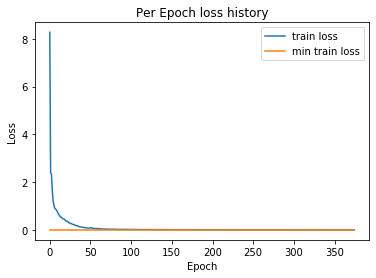

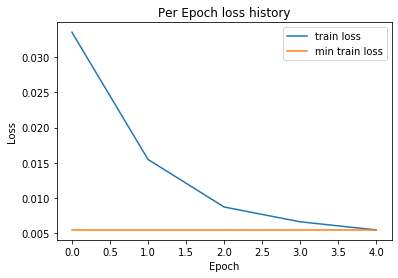

In [12]:
##PLOT LOSS, TRAIN ACCURACY, TEST ACCURACY
import matplotlib.pyplot as plt
per_epoch_loss_list_min = np.repeat(np.min(np.array([per_epoch_train_loss_list_self])),   len(per_epoch_train_loss_list_self))

loss_list_min = np.repeat(np.min(np.array([loss_list_self])),   len(loss_list_self))


# plot the loss history
# plt.subplot()
# plt.plot(loss_list_self)
# plt.xlabel('iteration')
# plt.ylabel('training loss')
# plt.title('Training Loss history')
# plt.legend()
# plt.show()

plt.subplot()
plt.plot(loss_list_self, label='train loss')
plt.plot(loss_list_min, label='min train loss')
plt.title('Per Epoch loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plt.subplot()
# plt.plot(train_accuracy_list, label='train')
# plt.plot(test_accuracy_list, label='val')
# plt.plot(max_train_accuracy, label='max train acc')
# plt.plot(max_test_accuracy, label='max val acc')
# plt.title('Classification accuracy history')
# plt.xlabel('Iteration')
# plt.ylabel('Classification accuracy')
# plt.legend()
# plt.show()

plt.subplot()
plt.plot(per_epoch_train_loss_list_self, label='train loss')
plt.plot(per_epoch_loss_list_min, label='min train loss')
plt.title('Per Epoch loss history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()



In [13]:
composed = transforms.Compose([
                                    transforms.Resize((200,300)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                              
                              ])

v_composed = transforms.Compose([
                                    transforms.Resize((60,100)),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                              
                              ])

root_dir = "/home/mandeep_stanford/cs231n_project/code/pre-processed_data/4_EMOTIONS/cb_removed/without_noise_cleanup/"
emotion_dataset = Emotion_Dataset(csv_file=root_dir + 'not_hap_data_TRAIN.csv',
                                    root_dir=root_dir, transform=composed, v_transform = v_composed)


loader_train = DataLoader(emotion_dataset, batch_size=64)

root_dir = "/home/mandeep_stanford/cs231n_project/code/pre-processed_data/4_EMOTIONS/cb_removed/without_noise_cleanup/"
emotion_dataset_val = Emotion_Dataset(csv_file=root_dir + 'not_hap_data_TEST.csv',
                                    root_dir=root_dir, transform=composed, v_transform = v_composed)

loader_val = DataLoader(emotion_dataset_val, batch_size=64)

print("Train Data Points", len(loader_train.dataset))
print("Test Data Points", len(loader_val.dataset))



#loader_train = DataLoader(emotion_dataset, batch_size=64, sampler=sampler.SubsetRandomSampler(range(0,train_data_images)))

#loader_val = DataLoader(emotion_dataset, batch_size=64, sampler=sampler.SubsetRandomSampler(range(train_data_images, train_data_images+test_data_images)))

Train Data Points 4800
Test Data Points 1200


In [14]:
class MyModel(nn.Module):
    def __init__(self, a1, v1):
        super(MyModel, self).__init__()
        self.a1 = a1
        self.v1 = v1
        self.fc1 = nn.Linear(64*2, 64)
        self.fc2 = nn.Linear(64, 4)
        
    def forward(self, a_img, v_img):
        x1 = self.a1(a_img)
        x2 =self.v1(v_img)
        x = torch.cat((x1, x2), dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
# class MyModel_audio(nn.Module):
#     def __init__(self, a1):
#         super(MyModel_audio, self).__init__()
#         self.a1 = a1
        
#     def forward(self, a_img):
#         x1 = self.a1(a_img)
#         return x1

# class MyModel_video(nn.Module):
#     def __init__(self, a1):
#         super(MyModel_video, self).__init__()
#         self.a1 = a1
        
#     def forward(self, a_img):
#         x1 = self.a1(a_img)
#         return x1
# model = MyModel(a_model, v_model)
# model_audio=MyModel_audio(a_model)
# model_video=MyModel_video(v_model)
best_audio_model=torch.load("best_model_audio_self_supervised_without_noise_cleanup_3sec_Time_Scale_50_epochs.pt")
best_video_model=torch.load("best_model_video_self_supervised_without_noise_cleanup_3sec_Time_Scale_50_epochs.pt")
model = MyModel(best_audio_model, best_video_model)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, 
                     betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
best_model, acc, train_accuracy_list, test_accuracy_list, per_epoch_train_accuracy_list, per_epoch_test_accuracy_list, loss_list=train_part34(model, optimizer, epochs=15)





Epoch 0, Iteration 0, loss = 1.4274
Checking accuracy on TRAIN set
Got 0 / 64 correct (0.00)
Checking accuracy on VAL set
Got 0 / 1200 correct (0.00)

Epoch 0, Iteration 20, loss = 1.1273
Checking accuracy on TRAIN set
Got 36 / 64 correct (56.25)
Checking accuracy on VAL set
Got 679 / 1200 correct (56.58)


/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type MyModel. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "



Epoch 0, Iteration 40, loss = 0.6874
Checking accuracy on TRAIN set
Got 45 / 64 correct (70.31)
Checking accuracy on VAL set
Got 773 / 1200 correct (64.42)

Epoch 0, Iteration 60, loss = 0.7044
Checking accuracy on TRAIN set
Got 42 / 64 correct (65.62)
Checking accuracy on VAL set
Got 779 / 1200 correct (64.92)

Checking accuracy on VAL set
Got 787 / 1200 correct (65.58)
Checking accuracy on TRAIN set
Got 3001 / 4800 correct (62.52)
Epoch 1, Iteration 0, loss = 0.8884
Checking accuracy on TRAIN set
Got 36 / 64 correct (56.25)
Checking accuracy on VAL set
Got 773 / 1200 correct (64.42)

Epoch 1, Iteration 20, loss = 0.7639
Checking accuracy on TRAIN set
Got 40 / 64 correct (62.50)
Checking accuracy on VAL set
Got 784 / 1200 correct (65.33)

Epoch 1, Iteration 40, loss = 0.6482
Checking accuracy on TRAIN set
Got 51 / 64 correct (79.69)
Checking accuracy on VAL set
Got 836 / 1200 correct (69.67)

Epoch 1, Iteration 60, loss = 0.6957
Checking accuracy on TRAIN set
Got 42 / 64 correct (65.

No handles with labels found to put in legend.


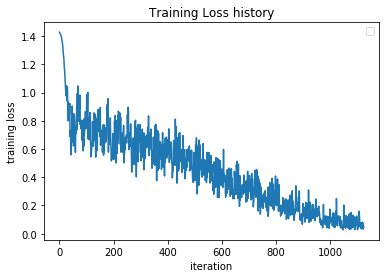

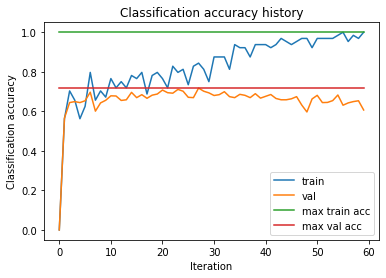

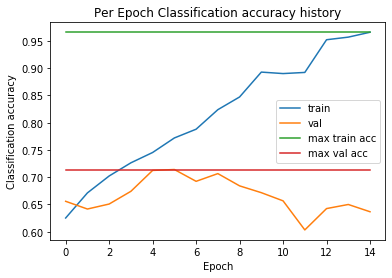

In [15]:
torch.save(best_model, "best_model_AV_CNN_RNN_3DCNN_without_noise_cleanup_3sec_Time_Scale_50_epochs")
torch.save(model, "model_AV_CNN_RNN_3DCNN_without_noise_cleanup_3sec_Time_Scale_50_epochs")

##PLOT LOSS, TRAIN ACCURACY, TEST ACCURACY
import matplotlib.pyplot as plt
max_train_accuracy = np.repeat(np.max(np.array([train_accuracy_list])),   len(train_accuracy_list))

max_test_accuracy = np.repeat(np.max(np.array([test_accuracy_list])),   len(test_accuracy_list))

max_p_e_train_accuracy = np.repeat(np.max(np.array([per_epoch_train_accuracy_list])),   len(per_epoch_train_accuracy_list))

max_p_e_test_accuracy = np.repeat(np.max(np.array([per_epoch_test_accuracy_list])),   len(per_epoch_test_accuracy_list))

# plot the loss history
plt.subplot()
plt.plot(loss_list)
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.legend()
plt.show()

plt.subplot()
plt.plot(train_accuracy_list, label='train')
plt.plot(test_accuracy_list, label='val')
plt.plot(max_train_accuracy, label='max train acc')
plt.plot(max_test_accuracy, label='max val acc')
plt.title('Classification accuracy history')
plt.xlabel('Iteration')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

plt.subplot()
plt.plot(per_epoch_train_accuracy_list, label='train')
plt.plot(per_epoch_test_accuracy_list, label='val')
plt.plot(max_p_e_train_accuracy, label='max train acc')
plt.plot(max_p_e_test_accuracy, label='max val acc')
plt.title('Per Epoch Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()



from sklearn.metrics import confusion_matrix
#from resources.plotcm import plot_confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    #
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.figure(figsize=(10,10))
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
def check_train_accuracy1(loader, model, for_confusion_matrix=0):
    #if loader.dataset.train:
    #    print('Checking accuracy on validation set')
    #else:
    #    print('Checking accuracy on test set')
    print('Checking accuracy on TRAIN set')
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    true_label_list = []
    predicted_label_list = []
    with torch.no_grad():
        for da in loader:
            x = da['image']
            y = da['emotion']
            v = da['video']
            y = y.reshape(y.shape[0])
            x = x.to(device)
            v = v.to(device)
            y = y.to(device)
            #pdb.set_trace()
            true_label_list.append(y.cpu().data.numpy())
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            #pdb.set_trace()
            #y = torch.stack(y) #.to(device=device)
            #y = y.reshape((x.shape[0]))
            scores = model(x,v)
            _, preds = scores.max(1)
            predicted_label_list.append(preds.cpu().data.numpy())            
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))
        if for_confusion_matrix == 1:
          return acc, true_label_list, predicted_label_list
        else:
          return acc
    
    


Checking accuracy on TRAIN set


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Got 3843 / 4800 correct (80.06)
Confusion matrix, without normalization
[[1298   13  289]
 [  27 1309  264]
 [ 229  135 1236]]


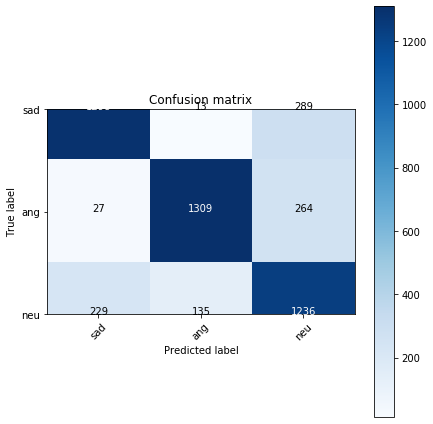

In [16]:
#best_model1 = torch.load("model2")
accuracy, true_label, predicted_label = check_train_accuracy1(loader_train, best_model, for_confusion_matrix=1)
true_label = np.concatenate(true_label, axis=None)
#print(true_label)

predicted_label = np.concatenate(predicted_label, axis=None)
#print(predicted_label)

emotion_dict = (
                'sad',
                'ang',
                'neu'
                )
cm = confusion_matrix(true_label, predicted_label)

#t_t = train_set_targets.cpu().data.numpy()
#predict = preds.cpu().data.numpy()
#t_t = 1 + t_t
#predict = 1 + predict

#for i in range(t_t.shape[0]):
#  print(t_t[i], predict[i])
#print(t_t)
#print(predict)
#print(cm)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, emotion_dict)

Checking accuracy on TRAIN set


/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/work/aten/src/ATen/native/cudnn/RNN.cpp:1266: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters().
/opt/conda/conda-bld/pytorch_1579022060824/wor

Got 861 / 1200 correct (71.75)
Confusion matrix, without normalization
[[306  21  73]
 [ 18 296  86]
 [102  39 259]]


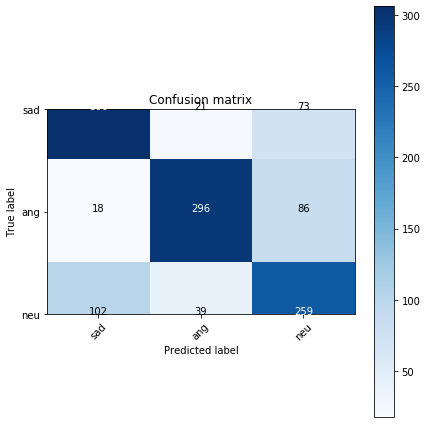

In [17]:
#best_model1 = torch.load("model1")
accuracy, true_label, predicted_label = check_train_accuracy1(loader_val, best_model, for_confusion_matrix=1)
true_label = np.concatenate(true_label, axis=None)
#print(true_label)

predicted_label = np.concatenate(predicted_label, axis=None)
#print(predicted_label)


cm = confusion_matrix(true_label, predicted_label)

#t_t = train_set_targets.cpu().data.numpy()
#predict = preds.cpu().data.numpy()
#t_t = 1 + t_t
#predict = 1 + predict

#for i in range(t_t.shape[0]):
#  print(t_t[i], predict[i])
#print(t_t)
#print(predict)
#print(cm)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cm, emotion_dict)

Checking accuracy on TRAIN set
Got 4637 / 4800 correct (96.60)
Confusion matrix, without normalization
[[1557    0   43]
 [   7 1567   26]
 [  33   54 1513]]


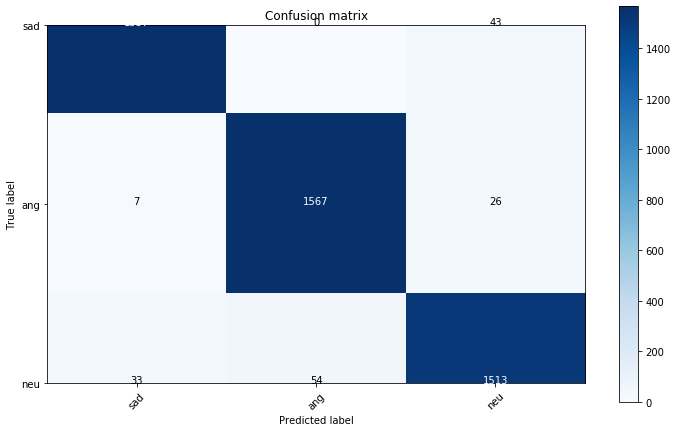

In [18]:
accuracy, true_label, predicted_label = check_train_accuracy1(loader_train, model, for_confusion_matrix=1)
true_label = np.concatenate(true_label, axis=None)
#print(true_label)

predicted_label = np.concatenate(predicted_label, axis=None)
#print(predicted_label)

emotion_dict = (
                'sad',
                'ang',
                'neu'
                )
cm = confusion_matrix(true_label, predicted_label)

#t_t = train_set_targets.cpu().data.numpy()
#predict = preds.cpu().data.numpy()
#t_t = 1 + t_t
#predict = 1 + predict

#for i in range(t_t.shape[0]):
#  print(t_t[i], predict[i])
#print(t_t)
#print(predict)
#print(cm)
plt.figure(figsize=(10,6))
plot_confusion_matrix(cm, emotion_dict)

Checking accuracy on TRAIN set
Got 764 / 1200 correct (63.67)
Confusion matrix, without normalization
[[262  23 115]
 [ 25 299  76]
 [134  63 203]]


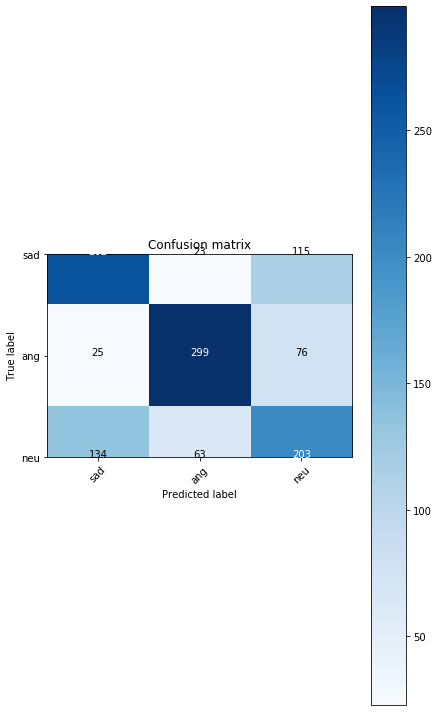

In [19]:
#best_model1 = torch.load("model1")
accuracy, true_label, predicted_label = check_train_accuracy1(loader_val, model, for_confusion_matrix=1)
true_label = np.concatenate(true_label, axis=None)
#print(true_label)

predicted_label = np.concatenate(predicted_label, axis=None)
#print(predicted_label)


cm = confusion_matrix(true_label, predicted_label)

#t_t = train_set_targets.cpu().data.numpy()
#predict = preds.cpu().data.numpy()
#t_t = 1 + t_t
#predict = 1 + predict

#for i in range(t_t.shape[0]):
#  print(t_t[i], predict[i])
#print(t_t)
#print(predict)
#print(cm)
plt.figure(figsize=(6,10))
plot_confusion_matrix(cm, emotion_dict)